## Plant leaf image preparation notebook with example images.

### Wrapper function that downloads, downscales, augments, & saves the downscaled & augmented images.

- This function is a standalone function that prepares a train-test split dataset for PyTorch neural network training starting from downloading the base TensorFlow data source.
    - All cells afterwards show the essential steps this function walks through in order to download, rescale (4000, 6000, 3) images to (150, 200, 3), augments the rescaled images, and saves a train-test split for neural network training.
    - Local dataset files for reduced & augmented images are saved according to config.yml

In [ ]:
from src.dataset_builder import download_and_prepare_dataset

download_and_prepare_dataset(label_target='categories', download_data_source=False)

    #label_target = ['categories', 'binary']
        #categories selects the leaf name labels from the subset list <leaves> in config.yml
        #binary selects all leafs with a healthy/unhealthy match and labels healthy leaves as 1 or unhealthy as 0

    #download_data_source = [T, F]
        #If True, will download the data source if it hasnt yet from TensorFlow datasets & save it locally to <local_file>
        
    #It will then use <local_file> as a starting point to apply image augmentations and save it to <local_file_augmented>

Training dataset length: 1467
Testing dataset length: 629
Augmented image dataset saved to ./data/augmented_leaves_dataset_categories.pkl


#### 1. Oringal TensorFlow data source

In [45]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from src.utils.constants import leaves_target_dict, combine_healthy_unhealthy_dict

ds_builder = tfds.builder('plant_leaves')
leaves = ds_builder.as_data_source(split='train')
info = ds_builder.info

print(f'Total unique plant_leaves labels in TensorFlow data source: {len(set(info.features["label"].names))}')

Total unique plant_leaves labels in TensorFlow data source: 22


In [46]:
#dictionary elements with image array, filename, and label
leaves[0]

{'image': array([[[46, 59, 76],
         [43, 56, 73],
         [39, 52, 69],
         ...,
         [34, 34, 44],
         [31, 31, 41],
         [28, 28, 38]],
 
        [[41, 54, 71],
         [39, 52, 69],
         [37, 50, 67],
         ...,
         [35, 35, 45],
         [32, 32, 42],
         [30, 30, 40]],
 
        [[40, 53, 70],
         [39, 52, 69],
         [39, 52, 69],
         ...,
         [35, 35, 45],
         [33, 33, 43],
         [31, 31, 41]],
 
        ...,
 
        [[25, 23, 26],
         [25, 23, 26],
         [25, 23, 26],
         ...,
         [21, 16, 20],
         [21, 16, 20],
         [21, 16, 20]],
 
        [[26, 24, 27],
         [26, 24, 27],
         [26, 24, 27],
         ...,
         [21, 16, 20],
         [21, 16, 20],
         [21, 16, 20]],
 
        [[26, 24, 27],
         [26, 24, 27],
         [26, 24, 27],
         ...,
         [21, 16, 20],
         [21, 16, 20],
         [21, 16, 20]]], dtype=uint8),
 'image/filename': b'0003_0096.JP

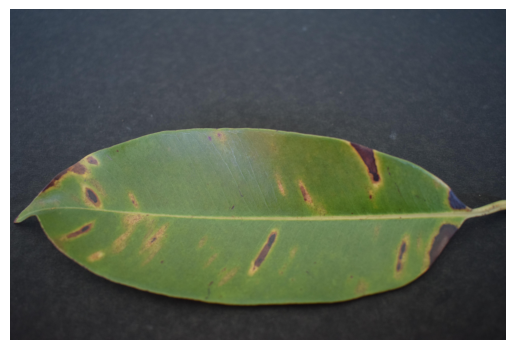

Image (height, width, channels): (4000, 6000, 3).
 
      These image sizes are too large to handle in even small batches for training.
      Images will be downscaled and saved locally at <base_file_path> from config.yml.
      


In [47]:
# Orignal image example:

plt.figure()
plt.imshow(leaves[100]['image'])
plt.axis('off')
plt.show()

print(f'''Image (height, width, channels): {leaves[0]["image"].shape}.\n 
      These image sizes are too large to handle in even small batches for training.
      Images will be downscaled and saved locally at <base_file_path> from config.yml.
      ''')

#### 2. Unique leaf examples after downscaling image size

Unique leaf labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique leaf names: ['Mango', 'Arjun', 'Alstonia', 'Gauva', 'Jamun', 'Jatropha', 'Pongamia', 'Pomegranate', 'Lemon', 'Chinar']


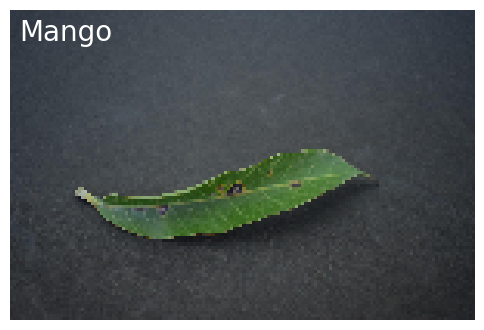

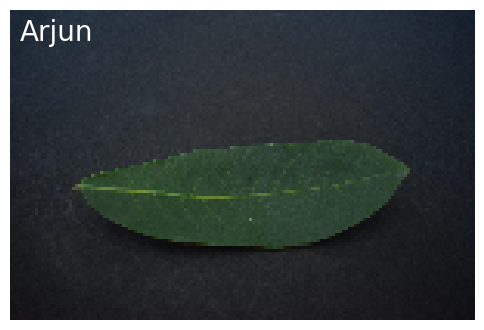

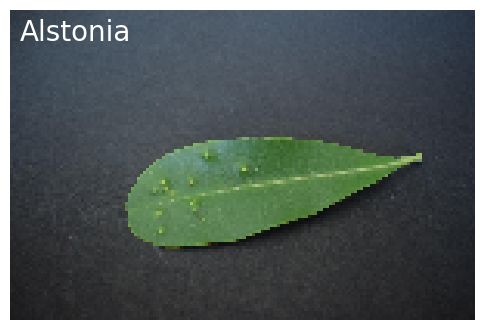

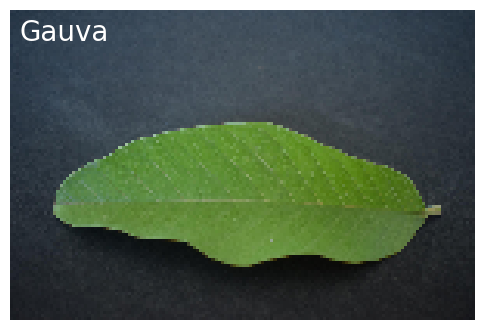

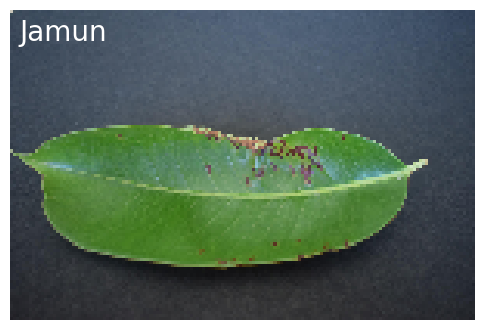

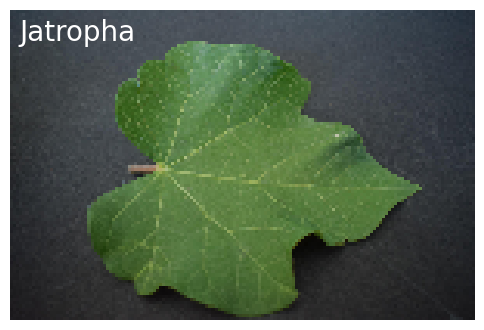

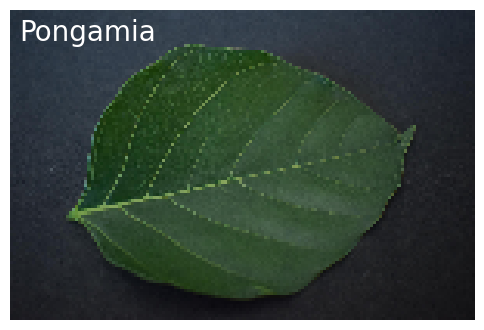

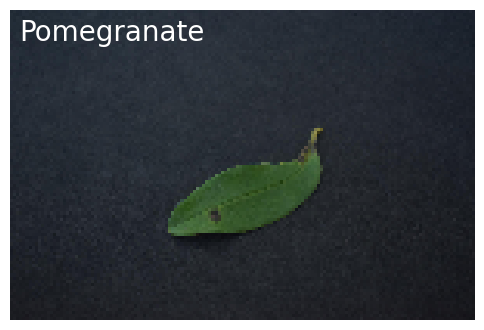

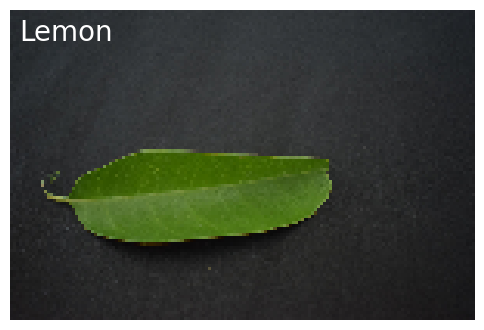

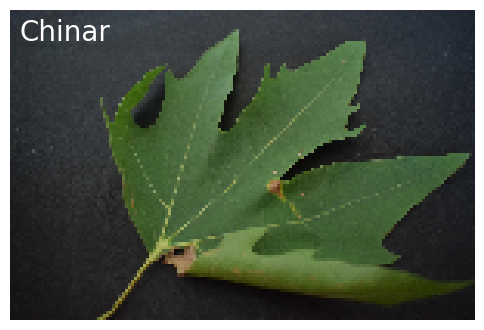

In [ ]:
import numpy as np
from src.utils.data_utils.load_dataset import load_leaves_dataset, combine_diseased_and_healthy, remove_unpaired_leaves

#Original tensorflow data source images reduced in image size, but not yet augmented:
x_train, x_test, y_train, y_test = load_leaves_dataset('./data/reduced_leaves_dataset.pkl',
                                                       0.3, target='categories', leaves_subset_list=None)


#Plot examples of all the different types of leaves
unique_leaves = sorted(set(y_train))
print(f'Unique leaf labels: {unique_leaves}')

dict_map_to_name = [{v:leaves_target_dict.get(k).split(' ')[0]} for k,v in combine_healthy_unhealthy_dict.items()]

unique_names_dict = {}
for d in dict_map_to_name:
    for k, v in d.items():
        if (k not in unique_names_dict) or (unique_names_dict[k] != v):
            unique_names_dict[k] = v

print(f'Unique leaf names: {[unique_names_dict.get(i) for i in unique_leaves]}')

for u in unique_leaves:
    idx = np.where(np.array(y_train) == u)[0][0]
    
    fig, ax = plt.subplots(figsize=(6,6))
    plt.imshow(x_train[idx])
    plt.text(0.02, 0.9, f'{unique_names_dict.get(u)}',fontsize=20, color='white', transform=ax.transAxes)
    plt.axis('off')
    plt.show()

#### 3. Grey masking 
- All leaf images were taken on a grey background. The grey can be masked via thresholding. Test examples shown below.
- Final grey threshold is set in config.yml and was implemented to focus more on the leaf color & shape in the CNN/HQNN.

Current config.yml chose grey_threshold of 10.


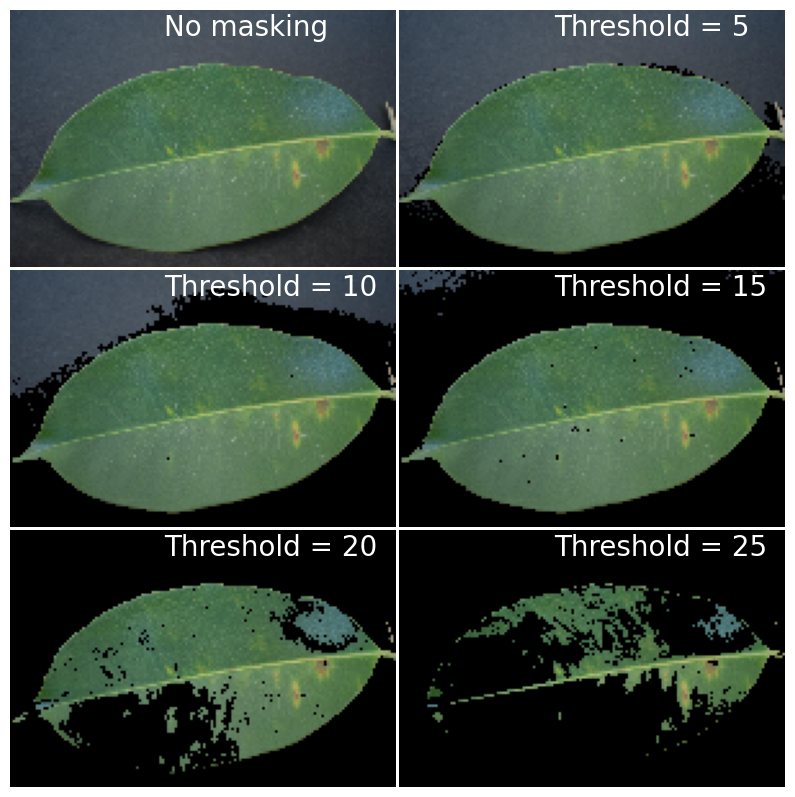

In [55]:
from src.utils.data_utils.prepare_images import mask_grey_background

print('Current config.yml chose grey_threshold of 10.')

threshold_tests = [5, 10, 15, 20, 25]
test_im = x_train[1500]
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10,15))
axes = axes.flatten()
ax1, ax2, ax3, ax4, ax5, ax6 = axes

xloc=0.4
yloc=0.9

ax1.imshow(test_im)
ax1.text(xloc, yloc, 'No masking',fontsize=20, color='white', transform=ax1.transAxes)
ax1.axis('off')

for idx, ax in enumerate([ax2, ax3, ax4, ax5, ax6]):
    ax.imshow(mask_grey_background(test_im, threshold_tests[idx]))
    ax.text(xloc, yloc, f'Threshold = {threshold_tests[idx]}',fontsize=20, color='white', transform=ax.transAxes)
    ax.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=-0.59)
plt.show()

#### 4. Other image augmentations with torchvision transformations

In [ ]:
# See prepare_images.py for the full code, but this snippet shows the transformations done on each image after grey masking

# Other transformations like random color jittering or saturation were tested but did not contribute to significant improvements
# in the fully classical CNN model.

transformations = transforms.Compose([
        transforms.Lambda(lambda x: x/255), #converts [0-255] RGB to [0-1] scale per channel
        transforms.CenterCrop((cropped_height_px, cropped_width_px)), #crops image closer to center of actual leaf
        transforms.RandomRotation(90), #randomized rotation to help CNN learning & prevent overfitting from invariant orientations
        transforms.RandomHorizontalFlip()]) #randomized flip for same reason as above



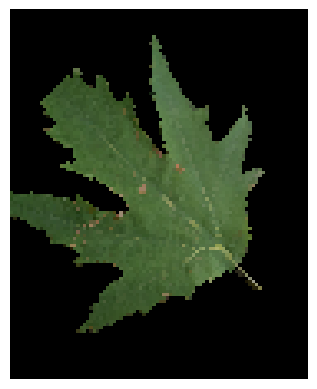

In [58]:
# Example image after augmentations

import pickle
from src.config.config import Config

DATA_CONFIG = Config.get('data')
AUGMENTED_DATA_SAVE_LOC = DATA_CONFIG.get('base_file_path') + DATA_CONFIG.get('local_file_augmented')

def convert_torch_for_plotting(torch_image, normalized=False):
    #converts torch tensor back to numpy to use with plt.imshow()
    if normalized:
        image = torch_image.permute(1,2,0).numpy()
        rescaled = image*255
        return rescaled.astype(np.uint8)
    
    return torch_image.permute(1,2,0).numpy().astype(np.uint8)

#Load augmented images
augmented_file_name = AUGMENTED_DATA_SAVE_LOC + f'_categories.pkl'
with open(augmented_file_name, 'rb') as f:
    loaded_data = pickle.load(f)

x_train = loaded_data['x_train']
x_test = loaded_data['x_test']
y_train = loaded_data['y_train']
y_test = loaded_data['y_test']

plt.figure()
plt.imshow(convert_torch_for_plotting(x_train[300], normalized=True))
plt.axis('off')
plt.show()

In [61]:
# Check the shape & content of the tensors saved in augmented dataset

# [samples, rgb_channels, width, height]
# height & width are further reduced from 150, 200 after cropping to 90, 112
    # Note - PyTorch shape expects [width, height] flipped from TensorFlow data source's input [height, width]
print(x_train.shape)  

# [samples]
print(y_train.shape)  

# image labels saved on dataset, these will be converted to integers {0, 1, 2, 3, 4} before running CNN training
print(set(y_train.numpy()))
print(set(y_test.numpy()))

torch.Size([1467, 3, 112, 90])
torch.Size([1467])
{0.0, 4.0, 5.0, 7.0, 9.0}
{0.0, 4.0, 5.0, 7.0, 9.0}
